# Пакет лучевого трассирования SeisLab
## Руководство для быстрого старта

Пакет SeisLab предназначен для расчёта синтетических волновых полей в приближении главного члена лучевого ряда. Алгоритмы, реализованные в пакете, основаны двух допущениях:
1. Рассматриваются только однородно-слоистые модели сред без выклинивания;
2. При построении лучей решается двухточечная задача.

Кроме них есть и другие, более локальные предположения. Они будут проявляться по мере продвижения по основным модулям SeisLab.

В этом руководстве будет приведена инструкция для как можно более быстрого начала работы с программой. Детальное описание работы всего-всего-всего здесь не даётся.

## Основные модули

In [1]:
# Импортируем библиотеки. Я не понимаю, почему, но "сковзной" импорт не работает.
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# Импортируем главные компоненты для лучевого моделирования
import sys
sys.path.insert(0, "C:/Users/USER/seislab") # Не нашёл другого решения, чтобы импортировать модули из внешней директории.
# ПРИ ЗАПУСКЕ НА ДРУГОМ ПК НЕОБХОДИМО ИСПРАВИТЬ ПУТЬ В ДИРЕКТОРИЮ!!!

from src.tprt import FlatHorizon,\
GridHorizon,\
ISOVelocity,\
Layer,\
Velocity_model,\
DilatCenter,\
RotatCenter,\
Receiver,\
Ray

Выше были импортированы наиболее значимые классы, фигурирующие в проекте. Некоторые из них являются дочерними к более общим сущностям. Так, классы FlatHorizon и GridHorizon наследуют методы класса Horizon. 

Названия классов более или менее соответсвуют физическим сущностям, которые эти классы описывают:

- FlatHorizon - класс, описывающий плоские геологические границы;
- GridHorizon - класс, описывающий криволинейные границы, заданные на сетке;
- ISOVelocity - класс, созданные для взаимодействия с изотропными скоростными моделями. По сути, объекты этого класса являются парами [Vp, Vs] с возможностью удобного (с точки зрения сейсмика) вызова любого из элементов;
- Layer - класс, описывающий геологические слои;
- Velocity_model - класс, описывающий скоростные (и плотностные, на самом деле) модели среды;
- DilatCenter - класс, описывающий источники типа центра расширения;
- RotatCenter - класс, описывающий источники типа центра вращения;
- Receiver - класс, описывающий приёмники;
- Ray - класс, описывающий лучи.

Ниже под "моделями", "слоями" или "горизонтами" будут иметься ввиду объекты соответствующих классов.
<hr>

## Создание модели*
### * На примере трёхслойной модели с одной плоской и одной криволинейной границами со следующими свойствами слоёв:
* Vp_1 = 2000 м/с, Vs_1 = 1000 м/с, Dens_1 = 2300 кг/м**3
* Vp_2 = 2500 м/с, Vs_2 = 1250 м/с, Dens_2 = 2400 кг/м**3
* Vp_3 = 3000 м/с, Vs_3 = 1500 м/с, Dens_3 = 2500 кг/м**3

В конструктор класса моделей передаются массивы скоростей, плотностей и горизонтов, из которых затем автоматически собирается слоистая модель. **Важно отметить, что свободная поверхность не моделируется, т.е. модель простирается на бесконечность "вверх" и "вниз".** Скорости и плотности создаются тривиально:

In [2]:
# Скорости волн в слое задаются объектами класса ISOVelocity, в конструктор которого подаются пары Vp, Vs.
# Желательно задавать скорости в м/с.
vel_1 = ISOVelocity(vp=2000, vs=1000)
vel_2 = ISOVelocity(vp=2500, vs=1250)
vel_3 = ISOVelocity(vp=3000, vs=1500)

In [3]:
# Плотности задаются напрямую - просто числами. Желательно задавать плостности в кг/м**3:
dens_1 = 2300
dens_2 = 2400
dens_3 = 2500

Создание горизонтов - более сложный процесс. Во-первых, есть два класса для горизонтов, и для создания каждого из них требуются разные данные. Во-вторых, **пользователь гарантирует, что задаваемые им горизонты не пересекаются в моделируемом участке среды и несёт личную ответственность за достоверность предоставленных сведений**.

В нашей трёхслойной всего две границы. Пусть одна из них (верхняя) будет <i>плоским горизонтом</i>.

Плоские горизонты задаются через глубину точки, лежащей на таком горизонте, её координаты на плоскости, угол и азимут падения горизонта, а также через дополнительный параметр - область задания горизонта:

In [4]:
hor_1 = FlatHorizon(depth=200,
                    anchor=np.array([0, 0]),
                    dip = 10, # угола падения В ГРАДУСАХ
                    azimuth=0, # азимут падения в ГРАДУСАХ
                    region = np.array([[- 1000, - 1000],
                                       [1000, 1000]]))

Стоит сказать несколько слов про последний аргумент в конструкторе. <i>Регион</i> является прямоугольной областью на плоскости, задаваемой в виде [[x_min, y_min], [x_max, y_max]], т.е. в виде массива, в котором явно задаются координаты противолежащих углов прямоугольника. **На данный момент это поле используется только при определении ганиц отрисовки горизонтов**.

Вторая граница будет <i>криволинейной</i>. Криволинейные границы в SeisLab задаются дискретно, на регулярной прямоугольной сетке. Для создания границы необходимы:
* Массив x_set = [x_0, x_1, ..., x_M]
* Массив y_set = [y_0, y_1, ..., y_N]
* Массив z_set = [[z_00, z_01, ..., z_0N], [z_10, z_11, ..., z_1N], ... , [z_M0, z_M1, ..., zMN]]

Пусть наша граница будет задана на сетке x_set = [- 1000, - 998, ..., 998, 1000], y_set = [- 1000, - 998, ..., 998, 1000]. В качестве функции границы возьмём медленно осциллирующий синус: z = 700 + 100 * sin(2 * pi * (x / 4000 + y / 4000)).

In [5]:
x_set = np.linspace(- 1000, 1000, 1001)
y_set = np.linspace(- 1000, 1000, 1001)

yy_set, xx_set = np.meshgrid(y_set, x_set)

z_set = 700 + 100 * np.sin(2 * np.pi * (xx_set + yy_set) / 4000)

Для создания криволинейной границы необходимо в конструктор подать все три массива - x_set, y_set и z_set. Опциональным агументом, повышающим устойчивость интерполяции к выбивающимся точкам, но понижающим общую точность интерполяции, подаётся булевская величина - True или False. Для целей этого руководства мы приравняем её False (т.е. этот триггер отключен):

In [6]:
hor_2 = GridHorizon(x_set=x_set,
                    y_set=y_set,
                    z_set=z_set,
                    bool_parab=False)

**Внутри конструктора вычисляются полиномиальные коэффициенты бикубической интерполяции**, что в имеющейся на данный момент имплементации является очень долгой процедурой (более пяти минут на компьютере с частотой процессора 1.8 ГГц, а сетка была не самой большой (процессор тоже далеко не мощный, но мысль, я надеюсь, понятна)). Поэтому есть возможность подать ещё одним аргументом уже готовый массив полиномиальных коэффициентов, если он был насчитан заранее. Это удобно, если одну и ту же границу нуно будет использовать во многих сериях вычислений.

Надо отметить, что <i>регион</i> в случае криволинейных границ явно не задаётся. Его границы определяются по входным массивам x_set и y_set.
<hr>
В конструктор модели последовательно передаются:
* массив скоростей;
* массив плотностей;
* массив номеров (если честно, не вполне знаю, зачем);
* массив границ

In [7]:
model = Velocity_model(np.array([vel_1, vel_2, vel_3]),
                       np.array([dens_1, dens_2, dens_3]),
                       np.array([1, 2, 3]),                      
                       [hor_1, hor_2])

<hr>

## Взаимодействие с моделью и её элементами

Модель состоит из слоёв, каждый из которых характеризуется номером, скоростями распространения волн, плотностью и двумя перекрывающими горизонтами (выше было отмечено, что первый номер в модели простирается на бесконечность "вверх", что реализуется в виде плоского горизонта на бесконечности).

In [8]:
layers = model.layers

print("Имя первого горизонта:", layers[0].name)
print("Скорость P-волн в первом слое равна", layers[0].get_velocity(0)["vp"], "м/с")
print("Скорость S-волн в первом слое равна", layers[0].get_velocity(0)["vs"], "м/с")
print("Плотность пород в первом слое равна", layers[0].get_density(), "кг/м**3")

Имя первого горизонта: 1
Скорость P-волн в первом слое равна 2000 м/с
Скорость S-волн в первом слое равна 1000 м/с
Плотность пород в первом слое равна 2300 кг/м**3


В предыдущей ячейке продемонстрирован вызов скоростей волн в слое. Метод layer.get_velocity(<i>something</i>) принимает в качестве аргумента любое число (на самом деле, <i>пока что</i> можно вместо числа подать список или строку). Это число сейчас ни на что не влияет, но в дальнейшем планируется его использование для нахождения скорости в заданном направлении для анизотропной среды.

Приписка ["vp"] или ["vs"] после вызова метода необходима, чтобы получить конкретную скорость. Без неё метод возвращает словарь из двух элементов:

In [9]:
layers[0].get_velocity(0)

{'vp': 2000, 'vs': 1000}

Вызов плостности не нуждается в дополнительных комментариях.
<hr>
Для вызова горизонтов, ограничивающих данный слой, используются отдельные методы класса Layer. Определённые выше hor_1 и hor_2 ограничивают сверху и снизу второй слой. Вызовем эти горизонты через него:

In [10]:
top_hor = layers[1].top
bottom_hor = layers[1].bottom

**Все горизонты в SeisLab должны являться дважды гладкими функциями вида z = z(x, y)**. В частности, бикубическая интерполяция строится именно из условия непрерывности второй производной.

У таких горизонтов в любой их точке определены:
* Глубина;
* Градиент;
* Нормаль;
* Вторые производные (=> кривизны).

Первые три величины могут быть получены следуюшим образом:

In [11]:
print("Глубина верхнего горизонта в точке с координатами x = 0, y - 0:", top_hor.get_depth(np.array([0, 0])), "м")
print("Градиент функции верхнего горизонта в точке с координатами x = 0, y - 0:",
      top_hor.get_gradient(np.array([0, 0])))
print("Нормаль к верхнему горизонту в точке с координатами x = 0, y - 0:",
      top_hor.get_normal(np.array([0, 0])))

Глубина верхнего горизонта в точке с координатами x = 0, y - 0: 200.0 м
Градиент функции верхнего горизонта в точке с координатами x = 0, y - 0: [ 0.17632698  0.        ]
Нормаль к верхнему горизонту в точке с координатами x = 0, y - 0: [-0.17364818 -0.          0.98480775]


**Нормаль к границе строится таким образом, что её компонента по z положительна**.

Вторые производные примечательны тем, что в теории лучевого метода они должны вычисляться, как правило, не в глобальной системе координат. На поверхность в некоторой точке падает луч, характеризующийся своим <i>направлением</i>. В точке падения строится локальная система координат, базисные векторы которой связаны с этим направлением и с нормалью к границе. Для вычисления лучевой амплитуды необходимо знать вторые производные функции поверхности в новой системе координат и матрицу перехода к этой системе.

Поэтому метод класса Horizon, находящий вторые производные и матрицу перехода, называется get_local_properties, и ему на вход передаются x- и y-координаты точки падения, а также вектор направления падающего луча:

In [12]:
# пусть вертикальный луч падает на нижний горизонт в точке с координатами x = 0, y = 0:
inc_vec = np.array([0, 0, 1])

z_11, z_12, z_22, tr_matr = bottom_hor.get_local_properties(np.array([0, 0]), inc_vec)

In [13]:
print("Матрица вторых производных поверхности в локальной системе координат:\n",
      np.array([[z_11, z_12], [z_12, z_22]]))

Матрица вторых производных поверхности в локальной системе координат:
 [[  9.15107624e-15   1.52000053e-27]
 [  1.52000053e-27  -9.60266376e-15]]


In [14]:
print("Матрица перехода в локальную систему координат:\n", tr_matr)
print("Нормаль к нижней границе в точке падения", bottom_hor.get_normal(np.array([0, 0])))

Матрица перехода в локальную систему координат:
 [[  6.90279901e-01  -7.07106781e-01  -1.53341640e-01]
 [  6.90279901e-01   7.07106781e-01  -1.53341640e-01]
 [  2.16857827e-01  -4.16333634e-17   9.76203198e-01]]
Нормаль к нижней границе в точке падения [-0.15334164 -0.15334164  0.9762032 ]


Заметьте, что третий столбец в матрице перехода в данном случае совпадает с нормалью к границе. Однако, в общем случае совпадения нет: локальная система координат строится с тем, чтобы ось z' в ней была направлена в ту же среду, куда и падающий луч, поэтому третий орт может как совпадать с нормалью, так и быть протвонаправлен ей.
<hr>

## Создание источников, приёмников и лучей*
### * На примере волны, отражённой от второй границы в заданной модели

В SeisLab на данный момент реализовано два типа точечных источников сейсмических волн - центр расширения (идеальный источник P-волн) и центр вращения (идеальный источник S-волн). Оба источника излучают в среду импульс Рикера с некоторой главной частотой.

Для создания источника необходимы:
* Главная частота импульса Рикера;
* Модель, в которую источник помещается;
* Координаты источника
* (только для центра вращения) ось вращения.

Создадим источник типа центра расширения, расположенный на поверхности z = 0 в точке с координатами x = - 500, y = 0 (т.е. в первом слое). В качестве главной частоты возьмём 25 Гц:

In [15]:
source_freq = 25
source_location = np.array([- 500, 0, 0])

In [16]:
source = DilatCenter(source_freq, model, source_location)

Приёмники характеризуются местоположением и ориентацией. Последнюю можно не задавать явно - по умолчанию оси чувствительности приёмника будут совпадать с осями глобальной системы координат.

Зададим поверхностную приёмную линию длиной в 500 м и с шагом 25 м:

In [17]:
rec_coordinates = np.arange(0, 525, 25)

receivers = np.empty(rec_coordinates.shape[0], dtype = Receiver)

for i in range(rec_coordinates.shape[0]):
    
    receivers[i] = Receiver([rec_coordinates[i], 0, 0], orientation = np.array([[1, 0, 0],
                                                                                [0, - 1, 0],
                                                                                [0, 0, - 1]]))

**Ориентация приёмников была выставлена так, чтобы их вертикальная ось чувствительности "смотрела" вверх. По умолчанию она направлена вниз, сонаправлено с осью глубин**.

Для построения лучей необходимо задаться так называемым <i>лучевым кодом</i>. Лучевой код - это массив элементов вида:

[<"вверх" или "вниз">, <номер слоя>, <тип волны>]

* "вверх" или "вниз" - число, 1 или - 1. Задаёт направление движения по модели;
* номер слоя - номер слоя, в котором распространется волна (нумерация слоёв - с нуля);
* тип волны - число, указывающее на тип волны. 0 - P-волна, 1 - S-волна;

Такой подход базируется на форме лучей в доступных для SeisLab моделях среды. В однородно-слоистых средах лучи являются ломаными кривыми, и лучевой код, по сути, задаёт последовательность сегментов этой ломаной.

Мы будем моделировать P-волны, отражённые от второй границы:

In [18]:
raycode = [[1, 0, 0],
           [1, 1, 0],
           [- 1, 1, 0],
           [- 1, 0, 0]]

**В SeisLab нет автоматической проверки лучевого кода на корректность для данной модели. Пользователь несёт личную ответственность за осмысленность подаваемой программе последовательности**.

Для создания лучей в конструктор необходимо подать:
* Источник;
* Приёмник;
* Модель;
* Лучевой код.

Создадим лучи, идущие из источника в каждый из приёмников:

In [19]:
rays = np.empty(receivers.shape[0], dtype = Ray)

for i in range(rays.shape[0]):
    
    rays[i] = Ray(source, receivers[i], model, raycode)

**Созданные только что лучи не являются лучами в строгом понимании этого слова. Их траектория случайна (узлы ломаной находятся на правильных границах, но траектория ломаной не является оптимальной с точки зрения времён пробега), а амплитуды выставлены единичными**. Необходимо оптимизировать полученные лучи, а затем посчитать правильную амплитуду вдоль них:

In [20]:
for i in range(rays.shape[0]):
    
    rays[i].optimize()
    rays[i].ray_amplitude = rays[i].compute_ray_amplitude()[0]

Для расчёта времени пробега волны и определения амплитуды на данной трассе в некоторый момент времени используются отдельные методы:

In [21]:
traveltime_curve = np.zeros(rays.shape[0]) # массив для годографа

record_time = np.linspace(0, 2, 2001) # дискретизованное время записи

seismogram_x = np.zeros((rays.shape[0], record_time.shape[0]), dtype=complex) # массив для сейсмограмм (x-компонента)
seismogram_y = np.zeros((rays.shape[0], record_time.shape[0]), dtype=complex) # массив для сейсмограмм (y-компонента)
seismogram_z = np.zeros((rays.shape[0], record_time.shape[0]), dtype=complex) # массив для сейсмограмм (z-компонента)

In [22]:
for i in range(rays.shape[0]):
    
    traveltime_curve[i] = rays[i].travel_time() # считаем время первых вступлений
    
    for j in range(record_time.shape[0]):
        
        seismogram_x[i, j], seismogram_y[i, j], seismogram_z[i, j] = rays[i].get_recorded_amplitude(record_time[j])
        # записываем амплитуду в приёмнике

## Графическое представление данных

**В SeisLab нет функции / метода вроде plot_model**. Для отрисовки модели и лучей необходимо вызвать методы классов Horizon и Ray, по очереди для каждого объектна в отдельности.

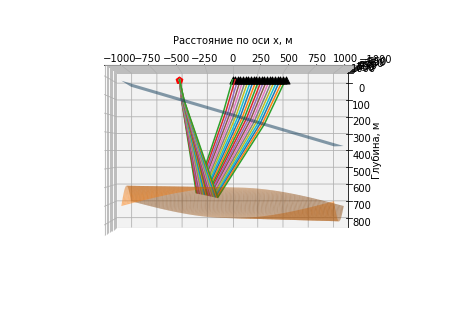

In [24]:
fig1 = plt.figure()
ax = Axes3D(fig1)
ax.invert_zaxis()

ax.view_init(0, - 90)

for layer in model.layers[:-1]:
    layer.bottom.plot(ax=ax)


source.plot(ax=ax, color='r', marker='p', s=50)

for i in range(rays.shape[0]):

    receivers[i].plot(ax=ax, color='k', marker='^', s=50)

    rays[i].plot(ax=ax)

# Create cubic bounding box to simulate equal aspect ratio
# max_range = np.array([horizons[-1].X.max()-horizons[-1].X.min(), horizons[-1].Y.max()-horizons[-1].Y.min(), horizons[-1].Z.max()-horizons[-1].Z.min()]).max()
# Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(horizons[-1].X.max()+horizons[-1].X.min())
# Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(horizons[-1].Y.max()+horizons[-1].Y.min())
# Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(horizons[-1].Z.max()+horizons[-1].Z.min())
# # Comment or uncomment following both lines to test the fake bounding box:
# for xb, yb, zb in zip(Xb, Yb, Zb):
#     ax.plot([xb], [yb], [zb], 'w')

ax.set_xlabel("Расстояние по оси x, м")
# ax.set_ylabel("Расстояние по оси y, м",)
ax.set_zlabel("Глубина, м")

plt.show()

Аналогично, **нет спецального метода для отрисовки сейсмограмм** - приходится сочинять что-то вроде этого:

C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:4846: ComplexWarning: Casting complex values to real discards the imaginary part
  X[1:N + 1, 1] = y1slice
C:\Users\USER\Anaconda3\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


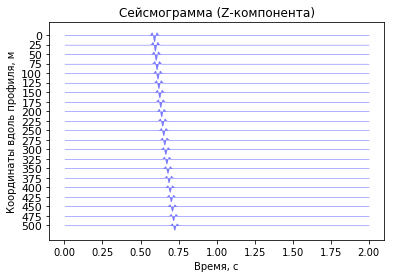

In [25]:
fig2 = plt.figure()

plt.title("Сейсмограмма (Z-компонента)")
plt.gca().invert_yaxis()

plt.yticks(np.arange(0, rays.shape[0], 1), np.round(rec_coordinates),
           fontsize = - 5 / 16 * rays.shape[0] + 11 + 21 * 5 / 16)

for i in range(rays.shape[0]):

    plt.fill_between(record_time, seismogram_z[i, :] / np.max(abs(seismogram_z)) / 1.5 + i,
                     np.ones(record_time.shape) * i,
                     linewidth = 0.3, color = 'b', alpha = 0.5)


plt.ylabel("Координаты вдоль профиля, м")
plt.xlabel("Время, с")

plt.show()

Питон выдаёт предупреждение о потере мнимой части сейсмограмм - и это тоже проблема, с которой пока что надо мириться.